Океей. Є два варіанти - запустити щось готове і адаптувати під себе, або трішки благотодніше - реалізувати щось власноруч.

Звісно благородно і більш показово було б якби я робив то сам - але треба бути приземленим і ближчим до реалій - **красти і адаптовувати**, щоб отримати працездатний продукт в короткі терміни.

На днях бачив новеньку роботу Yifan Wang∗ Xingyi He∗ Sida Peng Dongli Tan Xiaowei Zhou†
під назвою Efficient LoFTR: Semi-Dense Local Feature Matching with Sparse-Like Speed
*(👉Zhejiang unveils efficient LoFTR: novel LoFTR-inspired algorithm for efficien semidense matches across images: up to 2.5× faster than LoFTR, superior to previous SOTA pipeline (SuperPoint + LightGlue).)*

Копнув трішки під історію створення і вийшов на конференцію Computer Vision and Pattern Recognition Conference (CVPR). 

Вирішив, що якщо тут китайці+всесвітня конференція - то треба копнути сюди.

Перебрав фіналістів та призерів на всесвітньому конкурсі з якості та швидкодії, найновіші роботи були без коду, тому погляд опустив до 2020 року. Не супер актуально, але швидше реалізувати.


Я обрав той продукт, який сам перевіряв і порівнював для себе та був задоволений результатом - це **SuperGlue: Learning Feature Matching with Graph Neural Networks**

Компанії Magic Leap, Inc.
https://psarlin.com/superglue/

5хв налаштовування оточення під pytorch та CUDA (конфіг файл помістив в папці поряд з цим) - і вуаля - я бачу демку, яка працює на базі моєї веб-камери.  (conda env create -f condaenv.yml якщо уже є CUDA 11.3 в моєму випадку)

Старенька GTX-1650 на 4гб VRAM видала мені в режимі 640х480 - добротні 6.5 fps.
Візуально якість гарна, у кожного метчу є власний відсоток збігу, який відображається кольором на візуалізації.

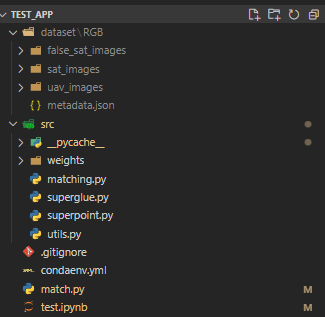


ось так виглядає структура (просто щоб було розуміння куди я кинув датасет)

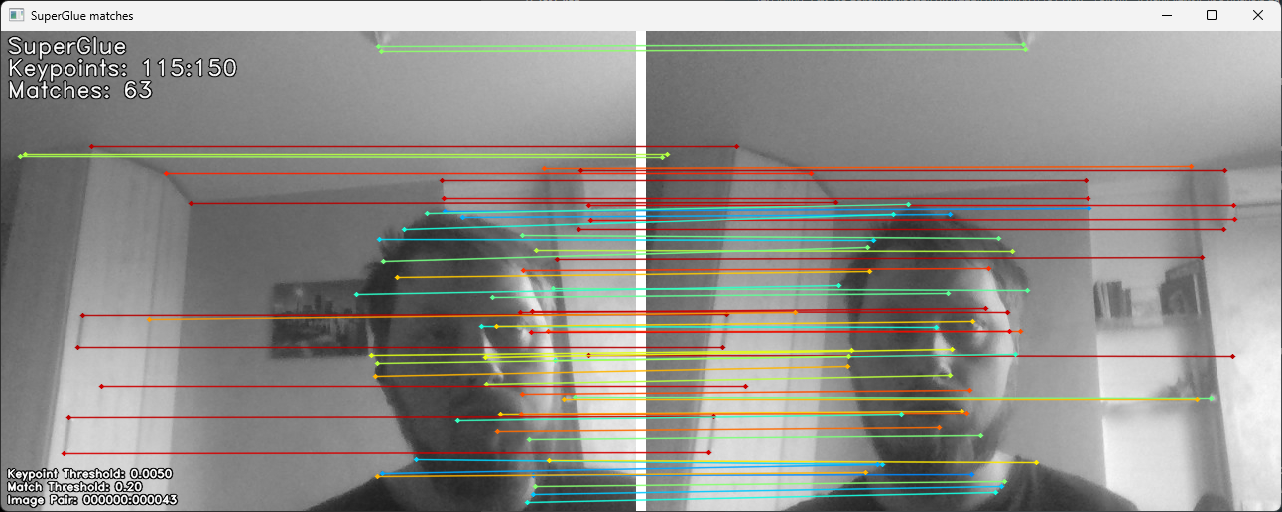

Нот бед, але треба спочатку потестувати на наших даних, а потім вивести метрику подібності.

Дефолтні імпорти...

In [14]:
import numpy as np
import matplotlib.cm as cm
import torch
import time

from src.matching import Matching
from src.utils import read_image

torch.set_grad_enabled(False)

Та конфіги проекту, підібрані оптимальні, для пришвидшення роботи, або для поліпшення точності - можна трішки погратися з ними.

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))
nkeypoints = 500
config = {
        'superpoint': {
            'nms_radius': 4, #SuperPoint Non Maximum Suppression (NMS) radius
            'keypoint_threshold': 0.005, #SuperPoint keypoint detector confidence threshold
            'max_keypoints': nkeypoints #Maximum number of keypoints detected by Superpoint
        },
        'superglue': {
            'weights': 'outdoor', #SuperGlue weights
            'sinkhorn_iterations': 20, #Number of Sinkhorn iterations performed by SuperGlue
            'match_threshold': 0.2 #SuperGlue match threshold
        }
    }
matching = Matching(config).eval().to(device)

Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


Підготовка завершена, час підвантажувати наші зображення. До прикладу візьмемо ці дві картинки
dataset\RGB\uav_images\DJI_0267.JPG

dataset\RGB\sat_images\DJI_0267.JPG

вони зняті над однією місцевістю, але з різних джерел


In [16]:
image0, inp0, scales0 = read_image("dataset\\RGB\\uav_images\\DJI_0267.JPG", device, [1024,840], 0, False)
image1, inp1, scales1 = read_image("dataset\\RGB\\sat_images\\DJI_0267.JPG", device, [1024,840], 0, False)

In [17]:
pred = matching({'image0': inp0, 'image1': inp1})
pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
matches, conf = pred['matches0'], pred['matching_scores0']

print(len(matches), "matches found")

500 matches found


На моєму ресайзі до 1024х840 і при використанні 1650 - кадр виконався за 0.6с. Це ок, бо є багато чого оптимізовувати.

In [18]:
valid = matches > -1
mkpts0 = kpts0[valid]
mkpts1 = kpts1[matches[valid]]
mconf = conf[valid]
color = cm.jet(mconf)
text = [
    'SuperGlue',
    'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
    'Matches: {}'.format(len(mkpts0)),
]

k_thresh = matching.superpoint.config['keypoint_threshold']
m_thresh = matching.superglue.config['match_threshold']
small_text = [
    'Keypoint Threshold: {:.4f}'.format(k_thresh),
    'Match Threshold: {:.2f}'.format(m_thresh),
    'Image Pair: {}:{}'.format("uav_images", "sat_images"),
]

# make_matching_plot(
#     image0, image1, kpts0, kpts1, mkpts0, mkpts1, color,
#     text, 'im.jpg', True,
#     True, False, 'Matches', small_text)

Маємо картинку з метчами.

Та наскільки коректно працює алгоритм.

Як я зрозумів - це прийнято робити - виписуючи ground truth info - реальну інфу про положення та висоту та порівнювати з результатами роботи алгоритму.
Такого собі дозволити не можу через фактор часу, тому буду імпровізувати і довіряти порахованим конфіденсам метчів.


In [19]:
print(np.average(conf))
goodOnesCount = np.sum(conf > 0.2)
print(goodOnesCount)

0.18017553
110


Середній конфіденс метчів становить 0.18, при цьому з 500 - лише 110 подолали мій поріг в 0.2 конфіденсу.

**Так як об'єктивно схожість 1 буде у картинки тільки у самої з собою - ми будемо працювати з меншими значеннями, задавши поріг та вважатимемо якесь значення як таке, що близьке до "картинки схожі"**

Просто вважати середній conf показником якості - **недоречно**, бо ми так можемо через однакову машину в місті і чистому полі вважати, що середній конф близький до 100. Тому, думаю, доречно **рахувати сумарний конф**. Це буде водночас і від якості сработок залежати і від їх кількості. А так як поріг кількості знайдених точок ми задаємо в залежності від ситуації (в цьому демо це 500), то ділитимемо на це число.

Щоб розуміти з чим ми маємо справу - ударимось трішки в емпірику і подивимось який результат буде з відносно різними картинками.


 **Пропишемо метод суцільним шматком для того, щоб було зручніше юзати.**
 

In [20]:
def calculateSimilarity(filename1:str, filename2:str):
    image0, inp0, scales0 = read_image(filename1, device, [1024,840], 0, False)
    image1, inp1, scales1 = read_image(filename2, device, [1024,840], 0, False)
    pred = matching({'image0': inp0, 'image1': inp1})
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
    matches, conf = pred['matches0'], pred['matching_scores0']
    return sum(conf)/nkeypoints

Подивимось які показники будуть у ідеального прикладу.

In [21]:
conf_city_different = calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", "dataset\\RGB\\sat_images\\DJI_0267.JPG"  )
print(conf_city_different)

0.1801755130251986


Маємо 0.18, число виглядає замалим, але так як воно відображає майже ідеальний випадок - уявімо, що воно близьке до 1 (наприклад 0.2 - це і є 1)

In [22]:
print(0.180175/0.2)

0.900875


Тобто на ідеальному прикладі маємо 0.9 умовних одиниць. Запам'ятали)

Надалі будемо переводити в цей проміжок по дефолту, для кращого розуміння.

In [23]:
conf_city_different = calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", "dataset\\RGB\\sat_images\\DJI_0542.JPG"  )
print(conf_city_different*5)

0.1608810055349022


Бачимо фото зверху та 0.16 conf.


Маємо не прям нульовий конф, бо порівнювали урбаністичну забудову зі схожими дахами та машинами на дорогах.

Візуально це виглядає так (нагадаю, що чим теплішим є колір - тим більший конфіденс у зв'язку і тим більш схожі "дескриптори" у точок)

Ми бачимо нікчемні намагання алгоритму знайти хоч щось спільше, але якось не виходить.

Скористаюся ще папочкою false_sat_images для переконання в тому, що все +-працює. візьму щось типу цього:

In [24]:
conf_city_different = calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", "dataset\\RGB\\false_sat_images\\(38.6057500118208,-90.18113253425659), (38.604808168409335, -90.17933211254105).jpg"  )
print(conf_city_different*5)

0.06253381341230124


Бачимо, що тут середній конфіденс становить уже 0.06, в 15 разів менший ніж на "схожих" які ми визначили на око. 

Оновлю основний метод, з урахуванням нашої поправки

In [43]:
def calculateSimilarity(filename1:str, filename2:str):
    image0, inp0, scales0 = read_image(filename1, device, [1024,840], 0, False)
    image1, inp1, scales1 = read_image(filename2, device, [1024,840], 0, False)
    pred = matching({'image0': inp0, 'image1': inp1})
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
    matches, conf = pred['matches0'], pred['matching_scores0']
    return (sum(conf)/nkeypoints)*5

Глянемо на час виконання, але врахуймо, що виконуються зайві обрахування початкового зображення ( я це лишаю для чистоти експеременту) але пам'ятаймо, що витрачений час можна скоротити майже вдвічі на продакшені

In [26]:
print("Схожі картинки, ймовірно в одному місці")
start = time.time()
print(calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0267.JPG", "dataset\\RGB\\uav_images\\DJI_0267.JPG"), "confidence level")
print(time.time() - start, " seconds")

print("\nДві картинки в контексті міста, але різні")
start = time.time()
print(calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0542.JPG", "dataset\\RGB\\uav_images\\DJI_0267.JPG"), "confidence level")
print(time.time() - start, " seconds")

print("\nМісто та ліс")
start = time.time()
print(calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0542.JPG", "dataset\\RGB\\false_sat_images\\(38.6057500118208,-90.18113253425659), (38.604808168409335, -90.17933211254105).jpg"), "confidence level")
print(time.time() - start, " seconds")

Схожі картинки, ймовірно в одному місці


0.9003741966682719 confidence level
0.6215205192565918  seconds

Дві картинки в контексті міста, але різні
0.16087818590924144 confidence level
0.6479701995849609  seconds

Місто та ліс
0.06987191567197443 confidence level
0.5486557483673096  seconds


Пора вводити якісь метрики (себто які пороги вважати адекватними). Продивлюся які будуть показники коли я прожену хоч пару сотень фото з false_sat.

In [27]:
import os
confs = []
for image in os.listdir("dataset\\RGB\\false_sat_images") [:200] :
    confs.append( calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0542.JPG", os.path.join("dataset\\RGB\\false_sat_images", image))  )

In [28]:
print(np.mean(confs))
print(np.median(confs))
print(np.max(confs))
print(np.min(confs))

0.09425806571073773
0.0915612084325403
0.30757099015638234
0.00038847820833325385


Бачимо максимум в 30%, мало і це ДОБРЕ!!! Дивимось далі.Візуалізую щільність 

In [29]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


<Axes: ylabel='Frequency'>

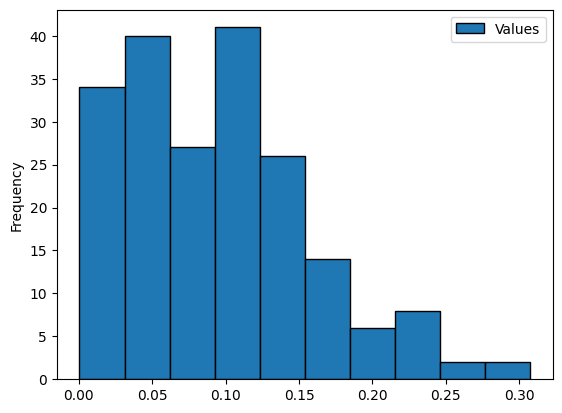

In [30]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')


0.1 перемагає, як і було в тексті вище. Тепер перевіримо що буде на нормальній папці, де присутні відповідні знімки.

In [31]:
import os
confs = []
for image in os.listdir("dataset\\RGB\\uav_images") [:100] :
    confs.append( calculateSimilarity("dataset\\RGB\\sat_images\\DJI_0267.JPG", os.path.join("dataset\\RGB\\uav_images", image))  )

In [32]:
print(np.mean(confs))
print(np.median(confs))
print(np.max(confs))
print(np.min(confs))

0.2959792364325363
0.20780686267418785
0.9299607823140105
0.08599142708815634


Подивимось на графік

<Axes: ylabel='Frequency'>

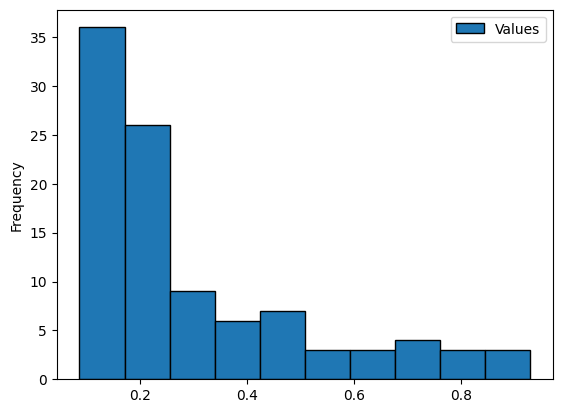

In [33]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')

Мода лишилась на рівні 0.1, але з'явився "Хвіст праворуч" та значення ближчі до 1. Все тому що ми додали даних, які трішки перекривають шукану зону.

Дослідимо який буде розподіл значень над тим перехрестям (знімок дорожньої розв'язки), на якому тестували.

In [34]:
import os
confs = []




for index in range(267, 274):

    confs.append( calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0267.JPG", os.path.join("dataset\\RGB\\sat_images\\", f"DJI_0{index}.JPG"))  )
    print(os.path.join("dataset\\RGB\\that_crossroad", image),confs[-1] )

dataset\RGB\that_crossroad\DJI_0366.JPG 0.900877565125993
dataset\RGB\that_crossroad\DJI_0366.JPG 0.9044929834060894
dataset\RGB\that_crossroad\DJI_0366.JPG 0.834931241251179
dataset\RGB\that_crossroad\DJI_0366.JPG 0.7360796963325266
dataset\RGB\that_crossroad\DJI_0366.JPG 0.5342496549642965
dataset\RGB\that_crossroad\DJI_0366.JPG 0.20163399162702264
dataset\RGB\that_crossroad\DJI_0366.JPG 0.10858321046922356


Всі тестові фото були відзняті на тому ж перехресті і з поступовим зсувом - зменшується поріг подібності до несуттєвих 0.3 і нижче, з цього можна припустити на даному етапі, що поріг - це число в 0.5~0.6

In [35]:
print(np.mean(confs))
print(np.median(confs))
print(np.max(confs))
print(np.min(confs))

0.6029783347394758
0.7360796963325266
0.9044929834060894
0.10858321046922356


<Axes: ylabel='Frequency'>

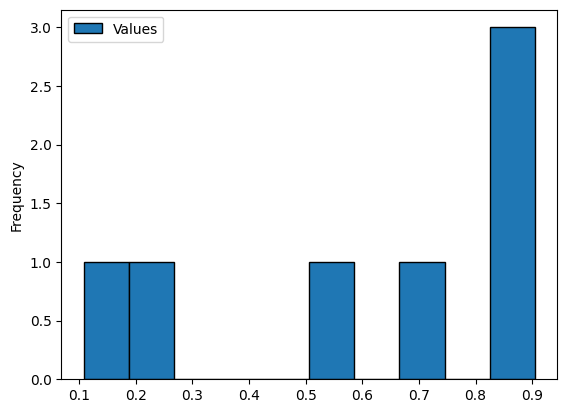

In [36]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')

Бачимо розподіл сработок на вибраному шматку даних. Далі розглянемо пари зображень та результат по ним.

In [37]:
print( calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0381.JPG", "dataset\\RGB\\sat_images\\DJI_0381.JPG") )

1.2536164388776525


Клас, цифра більша за 1, порушив початкові умови, але наразі - взагалі не знаю, як перевести все в чесні 0;1

In [38]:
print( calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0558.JPG", "dataset\\RGB\\sat_images\\DJI_0558.JPG") )


0.944436950936506


In [39]:
print( calculateSimilarity("dataset\\RGB\\uav_images\\DJI_0676.JPG", "dataset\\RGB\\sat_images\\DJI_0676.JPG") )

0.9648357043019495


Додам глобальні тестування на датасеті. Імена співпадають, тому просто будемо рахувати зміщення по іменам файлів. Так як це прольоти ... то будемо рахувати "відстань" до коректного файлу.

In [57]:
confs = []

for index in range(267,691):
    confs.append(calculateSimilarity( os.path.join("dataset\\RGB\\uav_images\\", f"DJI_0{index}.JPG"),  os.path.join("dataset\\RGB\\sat_images\\", f"DJI_0{index}.JPG")       ))

<Axes: ylabel='Frequency'>

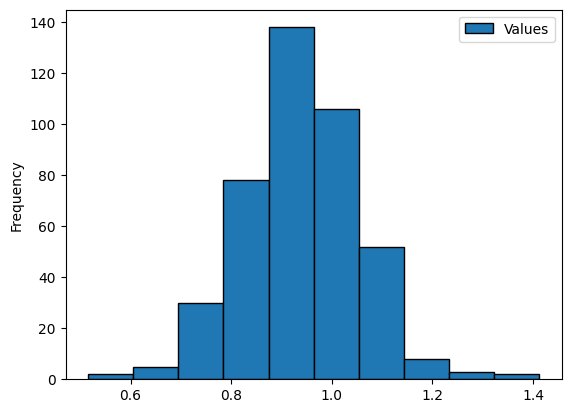

In [58]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')

Бачимо сильний перехід через межу в 1.

In [59]:
print(max(confs))

1.4121083679050206


Адаптуємо розмах очікуваних даних відповідно до цього датасету, бо більше нічого я не маю.

In [60]:
def calculateSimilarity(filename1:str, filename2:str):
    image0, inp0, scales0 = read_image(filename1, device, [1024,840], 0, False)
    image1, inp1, scales1 = read_image(filename2, device, [1024,840], 0, False)
    pred = matching({'image0': inp0, 'image1': inp1})
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
    matches, conf = pred['matches0'], pred['matching_scores0']
    return (sum(conf)/nkeypoints)*3.5408

Повторимо експеримент

In [69]:
confs = []

for index in range(267,691):
    confs.append(calculateSimilarity( os.path.join("dataset\\RGB\\uav_images\\", f"DJI_0{index}.JPG"),  os.path.join("dataset\\RGB\\sat_images\\", f"DJI_0{index}.JPG")       ))

0.6649597926604315


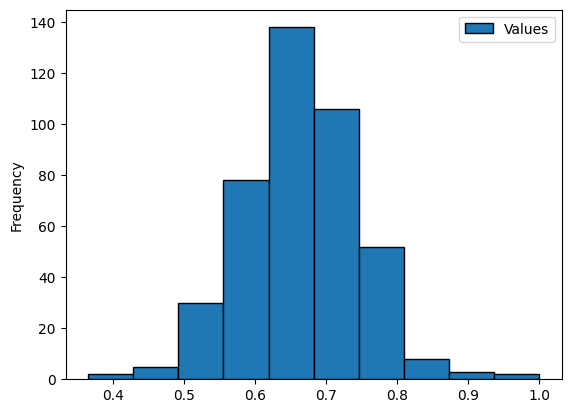

In [70]:
df = pd.DataFrame(confs, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')
print(np.average(confs))

Порахуємо відсоток промахів.

In [79]:
print("Відсоток промахів ", 100*( sum(1 for num in confs if num < 0.5)/425  ), "%")

Відсоток промахів  1.647058823529412 %


Окееей, 1.64% помилки це непогано, як на мене. Але взагалі не ок мати навіть таке.

Спробую ще зашафлити картинки і глянути які будуть результати на випадкових перевірках.

In [72]:
import random

confs_shufled = []

for index in range(267,691):
    confs_shufled.append(calculateSimilarity( os.path.join("dataset\\RGB\\uav_images\\", f"DJI_0{index}.JPG"),  os.path.join("dataset\\RGB\\sat_images\\", f"DJI_0{random.randint(267, 691)}.JPG")       ))

0.1702689731783275


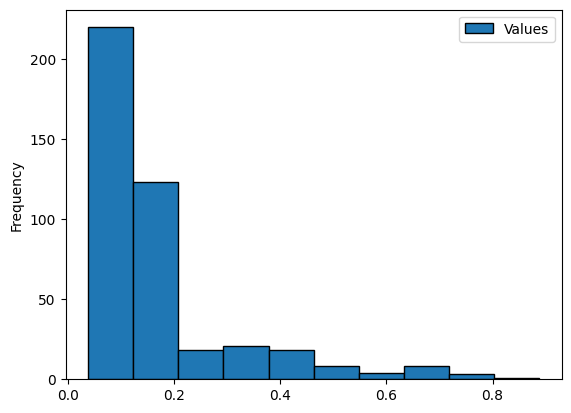

In [73]:
df = pd.DataFrame(confs_shufled, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')
print(np.average(confs_shufled))

Вооот. на рандомі більшість даних потрапили в проміжок 0-0.5, інші - можна вивести, але інформативності мало понесе, адже це рандом.

In [78]:
print( "Відсоток позитивних вердиктів на рандомних даних ",100*( sum(1 for num in confs_shufled if num >0.5)/425  ), "%")

Відсоток позитивних вердиктів на рандомних даних  4.705882352941177 %


Тобто 4% даних при випадкових порівняннях "триггернули" алгоритм.

Можна ще глянути які будуть результати якщо брати виключно сусідні зображення (для 1 брати 2, для 2 брати 3)

0.6279719918918614


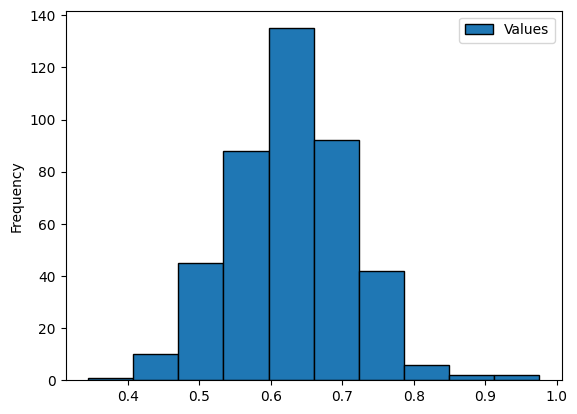

In [75]:
confs_nearby = []

for index in range(267,690):
    confs_nearby.append(calculateSimilarity( os.path.join("dataset\\RGB\\uav_images\\", f"DJI_0{index}.JPG"),  os.path.join("dataset\\RGB\\sat_images\\", f"DJI_0{index+1}.JPG")       ))
df = pd.DataFrame(confs_nearby, columns=['Values'])
df.plot.hist(bins=10, edgecolor='black')
print(np.average(confs_nearby))

In [76]:
print("Відсоток промахів ", 100*( sum(1 for num in confs_nearby if num < 0.5)/425  ), "%")

Відсоток промахів  5.176470588235294 %


фінальний код поміщу поряд з цим файлом для запуску з командного рядка



Швидкість не прям топ, 0.6с на моєму залізі. Але тут відбуваєтсья три операції. 

1 - видобування кейпоінтів з 1 фото
2 - видобування кейпоінтів з 2 фото
3 - порівняння кейпоінтів та фото

це можна скоротити та зекономити відсотків 20 часу.

**Також можна пожертвувати якістю та виконати більш потужний ресайз. Типу експерементувати є багато з чим і в кінці дійти до золотої середини**

А поки якість роботи на поточному датасеті оцінюю в **98.3%**

Дякую за увагу!!!)